In [1]:
# imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import pickle

# load calibration matrix
with open('calibration.pickle', 'rb') as f:
    mtx,dist = pickle.load(f)


In [3]:
# load perspective transform
with open('perspective.pickle', 'rb') as f:
    M,Minv = pickle.load(f)

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask. Copied from P1.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [60]:
# pipeline components
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def color_threshold(img):
    # R + U
    R = img[:,:,0]
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    U = luv[:,:,1]
    
    r_thresh = (200, 255)
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

    u_thresh = (120, 255)
    u_binary = np.zeros_like(U)
    u_binary[(U > u_thresh[0]) & (U <= u_thresh[1])] = 1

    combined_binary = np.zeros_like(R)
    combined_binary[((u_binary == 1) | (r_binary == 1))] = 1
    return combined_binary

def region_mask(img):
    buffer_bucket = 15

    xsize,ysize = img.shape[1],img.shape[0]

    x_buffer    = xsize / buffer_bucket

    lower_left  = (x_buffer,       ysize)
    lower_right = (xsize-x_buffer, ysize)
    top_left    = (xsize/2-10,     ysize/2+45) # normally the horizon is towards the bottom half
    top_right   = (xsize/2+10,     ysize/2+45)

    vertices = np.array([[
                lower_left,
                top_left,
                top_right,
                lower_right
            ]], dtype=np.int32)

    region = region_of_interest(img, vertices)

    return region

def perspective_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def get_curvature(leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval_left = np.max(lefty)
    y_eval_right = np.max(righty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def histogram_search(img):
    # get histogram
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    # fit polynomial
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    window_size = 100
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_size
        win_y_high = img.shape[0] - window*window_size
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty
    

def histogram_search_next(img, left_fit, right_fit):
    #print("searching from last histogram")
    # carry over from previous fit
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty



def draw_back(undistorted, warped, left_fit, right_fit):
    # Generate x and y values for plotting
    fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    return result

In [66]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # first pass?
        self.first_pass = True
        #radius of curvature of the line in some units
        self.curvature_left = None 
        self.curvature_right = None
        #current fit
        self.best_fit_lefts = []
        self.best_fit_rights = []
                
    def get_histogram_search(self, warped):
        if self.first_pass:
            return histogram_search(warped)
        else:
            return histogram_search_next(warped, self.current_fit_x, self.current_fit_y)
            
    
    def get_fit(self, leftx, lefty, rightx, righty):
        if self.first_pass:
            self.first_pass = False
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            # save curvature
            self.curvature_left, self.curvature_right = get_curvature(leftx,lefty,rightx,righty)
            # save fit
            self.best_fit_lefts.append(left_fit)
            self.best_fit_rights.append(right_fit)
            return left_fit, right_fit
        else:
            offset = 3
            try:
                curvature = get_curvature(leftx,lefty,rightx,righty)
                left_fit = np.polyfit(lefty, leftx, 2)
                right_fit = np.polyfit(righty, rightx, 2)
                
                if left_fit[0] * right_fit[0] >= 0: # same direction
                    self.best_fit_lefts.append(np.polyfit(lefty, leftx, 2))
                    self.best_fit_rights.append(np.polyfit(righty,rightx,2))
                    #print("last curvature:", self.curvature_left, self.curvature_right)
                    #print("current curvature", curvature)
                    self.curvature_left = curvature[0]
                    self.curvature_right = curvature[1]
                else:
                    #print("diff direction!")
                    pass
            except:
                pass
                        
            return np.mean(np.array(self.best_fit_lefts[-1*offset:]), axis=0).tolist(),np.mean(np.array(self.best_fit_rights[-1*offset:]), axis=0).tolist()          
            

In [39]:
def pipeline(img, line):
    
    #undistort
    undistorted = undistort(img)
    
    #color threshold
    combined_binary = color_threshold(undistorted)
    
    # region of interest
    region = region_mask(combined_binary)
    
    # perspective transform
    warped = perspective_transform(region)
    
    # get histogram search
    leftx,lefty,rightx,righty = line.get_histogram_search(warped)
    #print("leftx:", len(leftx), "rightx:", len(rightx))
    
    line.current_fit_x, line.current_fit_y = line.get_fit(leftx,lefty,rightx,righty)
    
    # draw back
    result = draw_back(undistorted, warped, line.current_fit_x, line.current_fit_y)
    
    return result

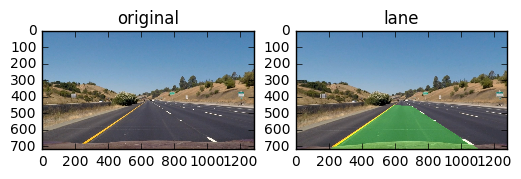

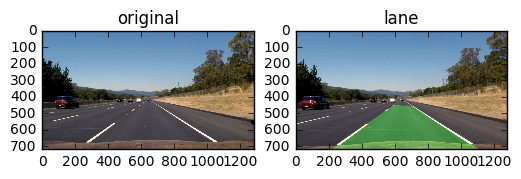

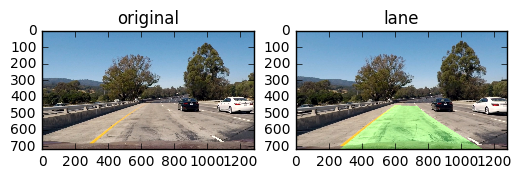

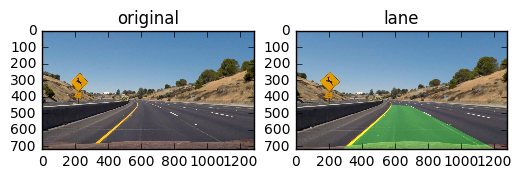

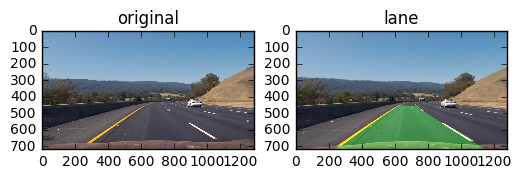

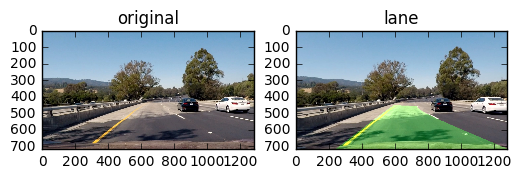

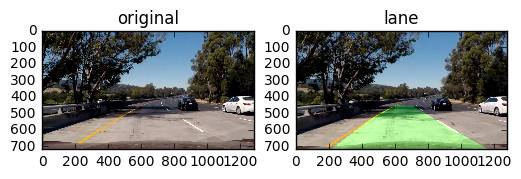

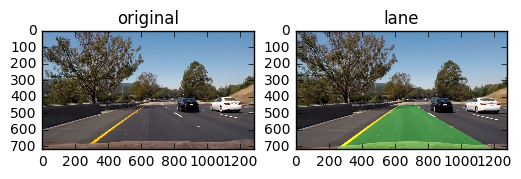

In [8]:
import glob
images = glob.glob('test_images/*.jpg')

line = Line()

for idx, fname in enumerate(images):
    line = Line()
    img = mpimg.imread(fname)
    #print("applying lane to image...", fname)
    plt.figure(idx+1)
    plt.subplot(1,2,1)
    plt.title("original")
    plt.imshow(img)
    
    lane = pipeline(img, line)
    plt.subplot(1,2,2)
    plt.title("lane")
    plt.imshow(lane, cmap='gray')
    plt.show()

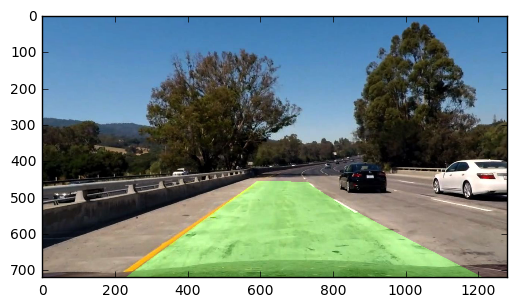

In [77]:
line = Line()

fname = 'input_sequence/problem_input 007.jpg'
img = mpimg.imread(fname)
lane = pipeline(img, line)
plt.imshow(lane,cmap='gray')


In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [86]:
%matplotlib inline
line = Line()
def process_image(img):
    global line
    return pipeline(img, line)

In [87]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:39<00:00,  4.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 15s, sys: 6.17 s, total: 8min 21s
Wall time: 4min 39s


In [88]:
print(len(line.best_fit_lefts))
print(len(line.best_fit_rights))

1045
1045


In [89]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))